## ✅ 1. Acceso a GPU.

Para aprovechar la aceleración de la GPU, se utiliza el comando  `nvidia-smi`. Esto es necesario, ya que el modelo SAM requiere un alto poder de procesamiento para ejecutar eficientemente las tareas de segmentación.

In [1]:
!nvidia-smi

Tue May  6 02:31:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   58C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## ✅ 2. Cargar Modelo y dependencias.

Instalación de SAM desde el repositorio github y dependencias para manejar funcionalidades de visualización y procesamiento de imagenes.

In [2]:
# Instalación de SAM
!pip install -q git+https://github.com/facebookresearch/segment-anything.git

  Preparing metadata (setup.py) ... done


In [3]:
# Instalación dependencias
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision==0.23.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 129.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 842.5/842.5 kB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.1 MB/s eta 0:00:00


## ✅ 3. Preparar entorno y cargar archivos necesarios.

Se definió la variable HOME con el proposito de facilitar la gestión de archivos en el entorno actual, también se creó una carpeta weights para guardar los archivos preentrenados. También, se habilita para subir la imagen a segmentar.

In [4]:
# Constante HOME para facilitar manejo de archivos.
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [5]:
!mkdir -p {HOME}/weights # crea carpeta weights.
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights # descarga el archivo de preentrenamiento de SAM y lo guarda en weights

In [6]:
import os
#guarda/establece la ruta del archivo de pre entreno en weights.
CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")

# imprime la ruta donde quedo el archivo de pre entrenamiento.
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [7]:
# Permite subir imagen local
from google.colab import files
uploaded = files.upload()

Saving monserrate.jpg to monserrate.jpg


## ✅ 4. Cargar el modelo y preparar la imagen para segmentación

Se carga el modelo SAM utilizando los pesos preentrenados, y se prepara la imagen de entrada para la segmentación. Además se verifica las dependencias para comenzar con el procesamiento.

In [8]:
import cv2
import os

filename = list(uploaded.keys())[0]  # obtiene el nombre del archivo subido
image_path = os.path.join(HOME, filename)
image = cv2.imread(image_path) # lee una imagen
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [9]:
# Cargar modelo
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [10]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

In [11]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [12]:
import os

IMAGE_NAME = "monserrate.jpg"
IMAGE_PATH = "/content/monserrate.jpg"

In [13]:
import cv2
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

In [14]:
print(sam_result[0].keys()) # visualización de las claves del resultado de segmentación

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


## ✅ 5. Visualización de las máscaras segmentadas.

Se utiliza el MaskAnnotator de la librería supervision (sv) para superponer las máscaras de segmentación sobre la imagen original y visualizar los resultados. El proceso incluye la anotación de la imagen con las máscaras generadas y la visualización de la imagen original junto con la imagen segmentada.

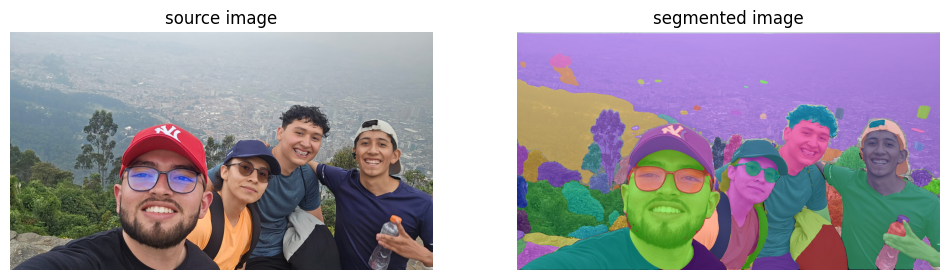

In [15]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)